In [1]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle, resample

## Load the data

In [2]:
news = pd.read_csv("/home/jupyter-ozkan_ma/data/CSV/news_preprocessed_with_addtionalLabel.csv", index_col=0)

In [3]:
# Get the same train and test data
def split_df_in_train_test(df):
    df = df.reset_index()
    split_point = int(np.round(df.shape[0]) * 0.8)
    df_train = df.loc[:split_point-1,:]
    df_test = df.loc[split_point:,:]
    return df_train, df_test

In [4]:
left_FE = resample(shuffle(news[(news["Label"]=="Left") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=15000)
leanLeft_FE = resample(shuffle(news[(news["Label"]=="Lean Left") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=15000)
center_FE = resample(shuffle(news[(news["Label"]=="Center") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=15000)
leanRight_FE = resample(shuffle(news[(news["Label"]=="Lean Right") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=15000)
right_FE = resample(shuffle(news[(news["Label"]=="Right") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=15000)

In [5]:
train = pd.concat([split_df_in_train_test(left_FE)[0], \
    split_df_in_train_test(leanLeft_FE)[0], \
    split_df_in_train_test(center_FE)[0], \
    split_df_in_train_test(leanRight_FE)[0], \
    split_df_in_train_test(right_FE)[0]])

In [6]:
test =  pd.concat([split_df_in_train_test(left_FE)[1], \
    split_df_in_train_test(leanLeft_FE)[1], \
    split_df_in_train_test(center_FE)[1], \
    split_df_in_train_test(leanRight_FE)[1], \
    split_df_in_train_test(right_FE)[1]])

In [7]:
x_train = train["content"].to_list()
y_train = train["Label"].to_list()
x_test = test["content"].to_list()
y_test = test["Label"].to_list()

In [8]:
class_names = list(train["Label"].unique())

## Build the model

In [9]:
model_name = "xlnet-base-cased"

In [10]:
t = text.Transformer(model_name, maxlen=512, class_names=class_names)

In [11]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 252
	95percentile : 481
	99percentile : 506


/home/jupyter-ozkan_ma/.conda/envs/oezkan_thesis/lib/python3.8/site-packages/ktrain/utils.py:573: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 256
	95percentile : 484
	99percentile : 506


In [12]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

In [13]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
10000/10000 [==============================] - 2314s 231ms/step - loss: 21.8182 - accuracy: 0.3071


done.
Visually inspect loss plot and select learning rate associated with falling loss


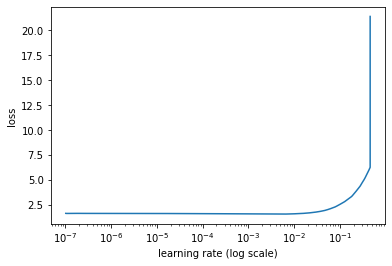

In [14]:
learner.lr_find(show_plot=True, max_epochs=1)

In [15]:
optimal_lr = learner.lr_estimate()[1]
print(optimal_lr)

0.00040476224385201933


In [16]:
learner.fit(optimal_lr, 1)

10000/10000 [==============================] - 7970s 797ms/step - loss: 1.6762 - accuracy: 0.2013 - val_loss: 1.6538 - val_accuracy: 0.2000


In [17]:
learner.validate(class_names=class_names)

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00      3000
   Lean Left       0.20      1.00      0.33      3000
      Center       0.00      0.00      0.00      3000
  Lean Right       0.00      0.00      0.00      3000
       Right       0.00      0.00      0.00      3000

    accuracy                           0.20     15000
   macro avg       0.04      0.20      0.07     15000
weighted avg       0.04      0.20      0.07     15000



/home/jupyter-ozkan_ma/.conda/envs/oezkan_thesis/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


array([[   0, 3000,    0,    0,    0],
       [   0, 3000,    0,    0,    0],
       [   0, 3000,    0,    0,    0],
       [   0, 3000,    0,    0,    0],
       [   0, 3000,    0,    0,    0]])